## 权重衰减解决过拟合问题（以线性回归为例）
通过限制模型参数来减小模型复杂性，避免过拟合的一种方法。要保证权重向量比较小， 最常用方法是将其范数作为惩罚项加到最小化损失的问题中。 将原来的训练目标最小化训练标签上的预测损失， 调整为最小化预测损失和惩罚项之和。

In [4]:
import torch
from torch import nn
from torch.utils import data
from d2l import torch as d2l

### 生成数据
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

In [3]:
def synthetic_data(w, b, num_examples):
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

### 初始化模型参数

In [10]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义L2范数惩罚项

In [8]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 训练模型

In [20]:
def train(lambd):
    w, b = init_params()
    # 这里net用了一个匿名函数，可以每次只传入不同的X，不必再传入w和b
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())
    print(w,b)

### 是否使用权重衰减

w的L2范数是： 13.559732437133789
tensor([[ 0.2345],
        [-1.4990],
        [-0.5286],
        [ 0.4603],
        [ 0.1239],
        [-0.3177],
        [ 1.9355],
        [-0.0331],
        [ 0.2297],
        [-0.8181],
        [ 1.2054],
        [ 0.2958],
        [ 0.7328],
        [-0.6857],
        [ 1.0976],
        [ 0.8038],
        [ 0.4251],
        [-0.5050],
        [-1.2863],
        [ 0.7647],
        [-0.0937],
        [ 0.0846],
        [-0.2060],
        [ 1.5563],
        [-0.4261],
        [-0.1264],
        [-1.1268],
        [ 0.0101],
        [-0.5458],
        [ 1.5713],
        [ 0.7307],
        [-1.1156],
        [-0.6845],
        [ 1.6602],
        [ 0.8234],
        [-0.1951],
        [ 0.6313],
        [-1.9306],
        [ 0.2203],
        [ 0.6400],
        [ 0.6466],
        [ 1.4472],
        [ 0.6431],
        [-1.2329],
        [-0.5078],
        [ 1.2217],
        [ 0.3090],
        [ 0.3186],
        [ 0.4130],
        [-0.1590],
        [-1.0553],
   

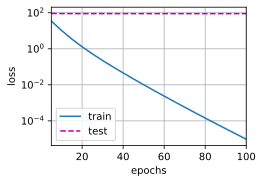

In [21]:
train(lambd=0)

w的L2范数是： 0.3735731840133667
tensor([[-2.4728e-02],
        [-1.9211e-02],
        [-2.2719e-02],
        [ 6.7595e-02],
        [ 5.4765e-03],
        [-1.1937e-02],
        [-3.7034e-02],
        [ 4.7177e-03],
        [-4.9992e-02],
        [-5.5956e-02],
        [ 5.5883e-03],
        [-3.5404e-02],
        [-6.5692e-04],
        [-1.1815e-03],
        [ 1.9117e-02],
        [-1.4042e-02],
        [-6.1684e-02],
        [-6.7307e-03],
        [ 2.6286e-02],
        [-1.1174e-02],
        [-2.4114e-02],
        [ 1.0799e-02],
        [-2.6306e-02],
        [ 1.7220e-02],
        [-4.4138e-02],
        [ 1.4321e-02],
        [ 6.4803e-03],
        [-2.1498e-02],
        [ 7.9202e-05],
        [-2.5198e-02],
        [ 1.4615e-04],
        [ 1.2984e-02],
        [ 3.9350e-02],
        [-8.2590e-03],
        [ 2.3130e-02],
        [-8.8967e-04],
        [ 2.4535e-02],
        [ 5.1532e-02],
        [ 1.5304e-02],
        [ 1.6838e-02],
        [ 1.5977e-02],
        [-3.2719e-02],
      

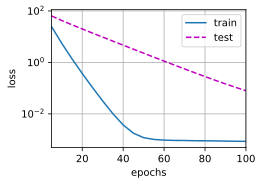

In [22]:
train(3)

### 简洁实现

In [23]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.582215309143066


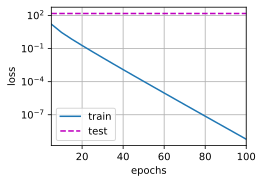

In [24]:
train_concise(0)

w的L2范数： 0.6994209885597229


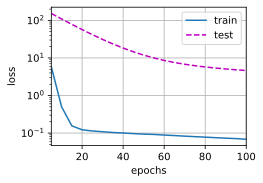

In [25]:
train_concise(3)